# Convolution: what it is, and two places it naturally appears
*(Signals & Systems + Probability, with worked Python examples)*

This notebook builds intuition for **convolution** and shows two standard places it appears:

1. **Linear time-invariant (LTI) systems**: output = input convolved with impulse response  
2. **Probability**: the PDF of a sum of independent random variables is a convolution of PDFs

We’ll do both conceptually and computationally, with small examples you can edit.



## 0. Setup

We'll use only NumPy + Matplotlib.  
(If you're in a signals course, you can later swap in `scipy.signal` utilities, but it's not required here.)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Pretty printing
np.set_printoptions(precision=4, suppress=True)


## 1. The definition

### Continuous-time
The convolution of two functions \(f\) and \(g\) is

\[
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau)\, g(t-\tau)\, d\tau
\]

### Discrete-time
For sequences \(x[n]\) and \(h[n]\),

\[
(x * h)[n] = \sum_{k=-\infty}^{\infty} x[k] \, h[n-k]
\]

**Interpretation:** a *weighted sum of shifted copies* of one signal, where the weights come from the other signal.

> In LTI systems, \(h\) is the **impulse response** and \(y = x*h\).


## 2. A "sliding dot-product" viewpoint (discrete)

In discrete time, think of convolution as:
1. pick an output index \(n\)
2. line up **all** pairs \(x[k]\) with \(h[n-k]\)
3. multiply pairwise and sum


In [2]:
def conv_sum(x, h):
    """Direct convolution using the definition (O(N^2))."""
    x = np.asarray(x)
    h = np.asarray(h)
    y = np.zeros(len(x) + len(h) - 1, dtype=float)
    for n in range(len(y)):
        s = 0.0
        for k in range(len(x)):
            j = n - k
            if 0 <= j < len(h):
                s += x[k] * h[j]
        y[n] = s
    return y

# Small example
x = np.array([1, 2, 1])
h = np.array([1, -1, 0.5])

y_manual = conv_sum(x, h)
y_np = np.convolve(x, h)

print("x =", x)
print("h =", h)
print("manual conv =", y_manual)
print("numpy conv  =", y_np)
print("max abs diff =", np.max(np.abs(y_manual - y_np)))


x = [1 2 1]
h = [ 1.  -1.   0.5]
manual conv = [ 1.   1.  -0.5  0.   0.5]
numpy conv  = [ 1.   1.  -0.5  0.   0.5]
max abs diff = 0.0


## 3. Example 1 (Signals): an LTI system as a smoothing filter

A classic LTI system is a **moving average** (a simple low-pass / smoothing filter):

\[
h[n] = \frac{1}{M}\, \underbrace{[1,1,\dots,1]}_{M\ \text{samples}}
\]

Then \(y = x * h\) is a local average of the last \(M\) samples (up to alignment conventions).

We'll create a noisy signal and smooth it with convolution.


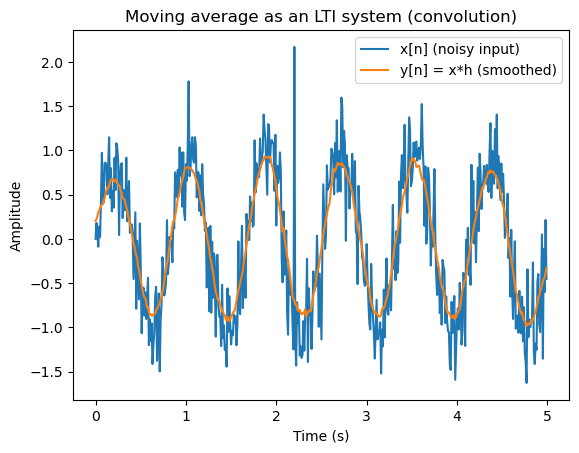

In [3]:
# Create a synthetic signal: sinusoid + noise + an impulse (to show the filter shape)
fs = 100  # Hz
t = np.arange(0, 5, 1/fs)
rng = np.random.default_rng(7)

x = np.sin(2*np.pi*1.2*t) + 0.35*rng.standard_normal(len(t))
x[int(2.2*fs)] += 3.0  # a spike

# Moving average impulse response
M = 25
h = np.ones(M)/M

# Convolve (mode='same' keeps length aligned to x for plotting convenience)
y = np.convolve(x, h, mode='same')

plt.figure()
plt.plot(t, x, label='x[n] (noisy input)')
plt.plot(t, y, label='y[n] = x*h (smoothed)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Moving average as an LTI system (convolution)')
plt.legend()
plt.show()


### 3.1 Impulse response intuition

If you input an impulse, the output of an LTI system is its **impulse response**.

Let's approximate an impulse (a single 1 surrounded by zeros) and see that convolving it with \(h\) gives back \(h\).


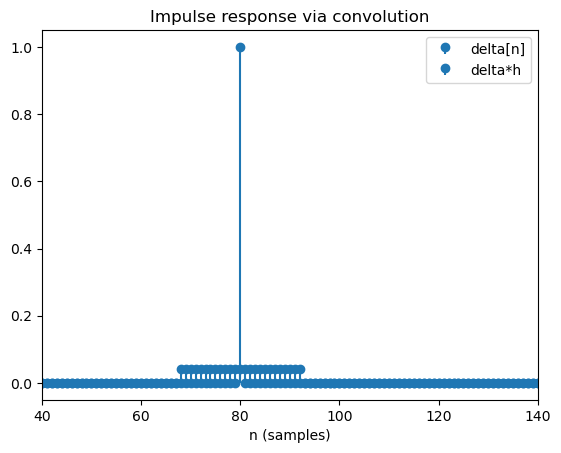

In [4]:
N = 200
delta = np.zeros(N)
delta[80] = 1.0  # discrete-time impulse at n=80

out = np.convolve(delta, h, mode='same')

plt.figure()
plt.stem(np.arange(N), delta, basefmt=" ", label='delta[n]')
plt.stem(np.arange(N), out, basefmt=" ", label='delta*h')
plt.xlim(40, 140)
plt.xlabel('n (samples)')
plt.title('Impulse response via convolution')
plt.legend()
plt.show()


### 3.2 Deconvolving your intuition: "shape modifies shape"

Convolution often feels like: *one shape gets “smeared” by another*.

- A narrow \(h\) (small \(M\)) smears a little → mild smoothing
- A wide \(h\) (large \(M\)) smears more → heavy smoothing but more delay/blur

Try changing `M` above.


## 4. Example 2 (Probability): adding independent random variables

If \(X\) and \(Y\) are independent random variables with PDFs \(f_X\) and \(f_Y\), then the PDF of \(Z=X+Y\) is

\[
f_Z(z) = (f_X * f_Y)(z)
\]

We'll show the classic result: **Uniform + Uniform = Triangular**.

We'll do it two ways:
- numerically convolving sampled PDFs
- Monte Carlo simulation (histogram of sums)


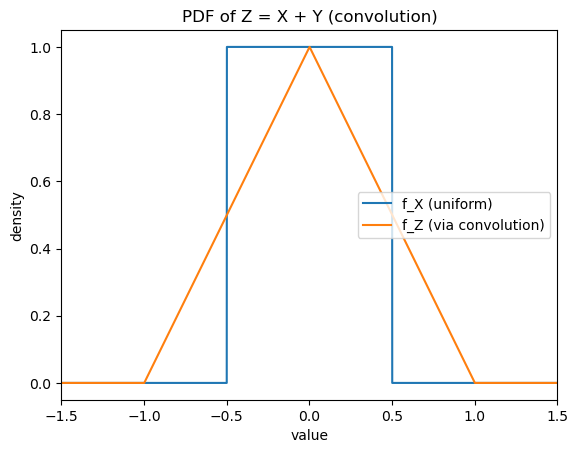

In [5]:
# Define a grid
dz = 0.001
z = np.arange(-2, 2+dz, dz)

def uniform_pdf(z, a=-0.5, b=0.5):
    out = np.zeros_like(z, dtype=float)
    out[(z >= a) & (z <= b)] = 1.0/(b-a)
    return out

f = uniform_pdf(z, -0.5, 0.5)  # X ~ U(-0.5, 0.5)
g = uniform_pdf(z, -0.5, 0.5)  # Y ~ U(-0.5, 0.5)

# Discrete approximation to continuous convolution:
# integral becomes a sum, so multiply by dz.
fz = np.convolve(f, g, mode='same') * dz

plt.figure()
plt.plot(z, f, label='f_X (uniform)')
plt.plot(z, fz, label='f_Z (via convolution)')
plt.xlim(-1.5, 1.5)
plt.xlabel('value')
plt.ylabel('density')
plt.title('PDF of Z = X + Y (convolution)')
plt.legend()
plt.show()


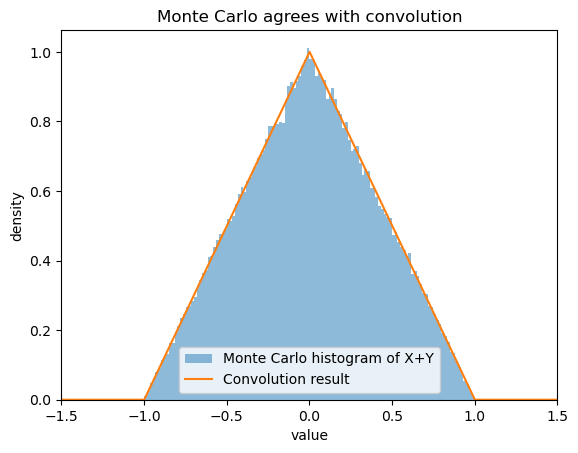

In [6]:
# Monte Carlo check
rng = np.random.default_rng(0)
N = 200000
X = rng.uniform(-0.5, 0.5, size=N)
Y = rng.uniform(-0.5, 0.5, size=N)
Z = X + Y

plt.figure()
plt.hist(Z, bins=120, density=True, alpha=0.5, label='Monte Carlo histogram of X+Y')
plt.plot(z, fz, label='Convolution result')
plt.xlim(-1.5, 1.5)
plt.xlabel('value')
plt.ylabel('density')
plt.title('Monte Carlo agrees with convolution')
plt.legend()
plt.show()


## 5. Optional: discrete-time convolution as polynomial multiplication

If you treat two finite sequences as polynomial coefficients, convolution corresponds to multiplying polynomials.
That’s one reason convolution is so common in DSP, control, and probability.

Try this with small vectors and compare:
- `np.convolve(x, h)`
- `np.polynomial.polynomial.polymul(x, h)`


In [7]:
x = np.array([1, 2, 1])
h = np.array([1, -1, 0.5])

print('np.convolve:', np.convolve(x, h))
print('polymul   :', np.polynomial.polynomial.polymul(x, h))


np.convolve: [ 1.   1.  -0.5  0.   0.5]
polymul   : [ 1.   1.  -0.5  0.   0.5]


## 6. Practice problems

1. **Smoothing and lag**  
   Use a moving average of length `M=5`, `M=25`, `M=101`.  
   What changes in the output? Where do you see “lag” or “blur”?

2. **Edge effects**  
   Try `mode='full'`, `'same'`, and `'valid'` in `np.convolve`.  
   Explain the output lengths.

3. **A simple differentiator**  
   Use `h = [1, -1]` and convolve with a smooth sinusoid.  
   What does the output resemble?

4. **Probability**  
   Replace uniform distributions with:
   - Gaussian + Gaussian (should remain Gaussian)
   - Uniform + Gaussian (becomes a smoothed uniform)  
   Use Monte Carlo to verify.


## References

- Convolution definitions and properties: Wikipedia, *Convolution*.  
- Convolution of probability distributions and sums of independent RVs: Wikipedia, *Convolution of probability distributions*.  
- Discrete-time convolution as LTI system output (intro text): Signals & Systems (Baraniuk et al., LibreTexts).  
